In [83]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as ss
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Кейс №2 - Приложение доставки

Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

В данных вы найдете логи заказов пользователей:

**ab_users_data** – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи \
**ab_orders** – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ \
**ab_products** – подробная информация о продуктах, их название и стоимость

In [18]:
orders = pd.read_csv('./ab_orders.csv')
users = pd.read_csv('./ab_users_data.csv')
products = pd.read_csv('./ab_products.csv')

Начнём с изучения имеющихся у нас данных.

In [32]:
orders.head()

,order_id,creation_time,product_id
0,1255,2022-08-26 00:00:19.000000,75
0,1255,2022-08-26 00:00:19.000000,22
0,1255,2022-08-26 00:00:19.000000,53
0,1255,2022-08-26 00:00:19.000000,84
1,1256,2022-08-26 00:02:21.000000,56


In [20]:
users.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [21]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [22]:
users.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

Видим, что в таблице с пользователями есть информация как о создании заказов, так и об их отмене. Это стоит запомнить на будущее.

In [23]:
users.query('order_id == "40498"')

,user_id,order_id,action,time,date,group
3787,1125,40498,create_order,2022-09-05 01:05:04.000000,2022-09-05,1
3791,1125,40498,cancel_order,2022-09-05 01:10:48.432260,2022-09-05,1


In [24]:
orders.dtypes

order_id          int64
creation_time    object
product_ids      object
dtype: object

Теперь перейдём к преобразованию данных.
Для начала уберём все скобки из строки с идентификаторами товара внутри заказа, затем разделим по запятой и пробелу, чтобы превратить колонку в массив.

In [25]:
orders.product_ids = orders.product_ids.str.replace(r'[{}]', '', regex=True)
orders.product_ids = orders.product_ids.str.split(', ')
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]"
1,1256,2022-08-26 00:02:21.000000,"[56, 76, 39]"
2,1257,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]"
3,1258,2022-08-26 00:02:56.000000,"[74, 6]"
4,1259,2022-08-26 00:03:37.000000,"[20, 45, 67, 26]"


После чего разобьём получившийся массив так, чтобы у каждого идентификатора товара была своя уникальная запись:

In [26]:
orders = orders.explode('product_ids')
orders.product_ids = pd.to_numeric(orders.product_ids)
orders = orders.rename(columns={'product_ids': 'product_id'})
orders.head()

,order_id,creation_time,product_id
0,1255,2022-08-26 00:00:19.000000,75
0,1255,2022-08-26 00:00:19.000000,22
0,1255,2022-08-26 00:00:19.000000,53
0,1255,2022-08-26 00:00:19.000000,84
1,1256,2022-08-26 00:02:21.000000,56


Далее объединим все три наших массива в один:

In [27]:
df = users.merge(orders, on='order_id')
df = df.merge(products, on='product_id')
df.head()

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,75,сок ананасовый,120.0
1,987,1287,create_order,2022-08-26 00:31:36.000000,2022-08-26,0,2022-08-26 00:31:36.000000,75,сок ананасовый,120.0
2,1073,1403,create_order,2022-08-26 03:01:40.000000,2022-08-26,1,2022-08-26 03:01:40.000000,75,сок ананасовый,120.0
3,1089,1424,create_order,2022-08-26 04:01:22.000000,2022-08-26,1,2022-08-26 04:01:22.000000,75,сок ананасовый,120.0
4,1139,1495,create_order,2022-08-26 06:04:05.000000,2022-08-26,1,2022-08-26 06:04:05.000000,75,сок ананасовый,120.0


Разнесём данные о группах по разным массивам. 

In [28]:
control_group = df.query('group == 0')
control_group.head()

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,75,сок ананасовый,120.0
1,987,1287,create_order,2022-08-26 00:31:36.000000,2022-08-26,0,2022-08-26 00:31:36.000000,75,сок ананасовый,120.0
6,1350,1791,create_order,2022-08-26 11:18:28.000000,2022-08-26,0,2022-08-26 11:18:28.000000,75,сок ананасовый,120.0
7,1475,1957,create_order,2022-08-26 13:47:21.000000,2022-08-26,0,2022-08-26 13:47:21.000000,75,сок ананасовый,120.0
12,1634,2199,create_order,2022-08-26 17:28:53.000000,2022-08-26,0,2022-08-26 17:28:53.000000,75,сок ананасовый,120.0


In [29]:
test_group = df.query('group == 1')
test_group.head()

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
2,1073,1403,create_order,2022-08-26 03:01:40.000000,2022-08-26,1,2022-08-26 03:01:40.000000,75,сок ананасовый,120.0
3,1089,1424,create_order,2022-08-26 04:01:22.000000,2022-08-26,1,2022-08-26 04:01:22.000000,75,сок ананасовый,120.0
4,1139,1495,create_order,2022-08-26 06:04:05.000000,2022-08-26,1,2022-08-26 06:04:05.000000,75,сок ананасовый,120.0
5,1290,1710,create_order,2022-08-26 10:04:41.000000,2022-08-26,1,2022-08-26 10:04:41.000000,75,сок ананасовый,120.0
8,1547,2064,create_order,2022-08-26 15:29:53.000000,2022-08-26,1,2022-08-26 15:29:53.000000,75,сок ананасовый,120.0


Так как задачей является оценить то, принесла ли новая версия пользу бизнесу и пользователям, то нужно определить метрики, по которым можно это изучить.

Таким образом можно, например, изучить среднее количество продуктов в заказе, средний чек заказа, процент отмены заказов.

Начнём со среднего количества продуктов в заказе.

In [33]:
control_group_orders = control_group.groupby('user_id', as_index=False).agg({'order_id':'nunique', 'product_id': 'count', 'price': 'sum'})
control_group_orders.head()

,user_id,order_id,product_id,price
0,964,2,8,718.9
1,966,1,4,170.0
2,968,3,11,1590.7
3,969,2,8,681.9
4,972,1,5,546.4


In [34]:
control_group_orders['avg_products_per_order'] = control_group_orders.product_id / control_group_orders.order_id
control_group_orders['avg_order_value'] = control_group_orders.price / control_group_orders.order_id
control_group_orders.head()

,user_id,order_id,product_id,price,avg_products_per_order,avg_order_value
0,964,2,8,718.9,4.000000,359.450000
1,966,1,4,170.0,4.000000,170.000000
2,968,3,11,1590.7,3.666667,530.233333
3,969,2,8,681.9,4.000000,340.950000
4,972,1,5,546.4,5.000000,546.400000


In [36]:
test_group_orders = test_group.groupby('user_id', as_index=False).agg({'order_id':'nunique', 'product_id': 'count', 'price': 'sum'})
test_group_orders.head()

,user_id,order_id,product_id,price
0,965,9,33,4155.5
1,967,5,18,1137.4
2,970,2,7,802.8
3,971,5,19,1968.4
4,973,4,14,1727.4


In [37]:
test_group_orders['avg_products_per_order'] = test_group_orders.product_id / control_group_orders.order_id
test_group_orders['avg_order_value'] = test_group_orders.price / control_group_orders.order_id
test_group_orders.head()

,user_id,order_id,product_id,price,avg_products_per_order,avg_order_value
0,965,9,33,4155.5,16.500000,2077.75
1,967,5,18,1137.4,18.000000,1137.40
2,970,2,7,802.8,2.333333,267.60
3,971,5,19,1968.4,9.500000,984.20
4,973,4,14,1727.4,14.000000,1727.40


In [38]:
cg_products_per_order = control_group_orders[['user_id', 'avg_products_per_order']]
tg_products_per_order = test_group_orders[['user_id', 'avg_products_per_order']]

Посмотрим на среднее количество заказов в целом в каждой из выборок:

In [61]:
cg_products_per_order.avg_products_per_order.mean()

3.5338501681705567

In [62]:
tg_products_per_order.avg_products_per_order.mean()

8.013690642027296

Обязательно посмотрим на распределение рассматриваемого признака:

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


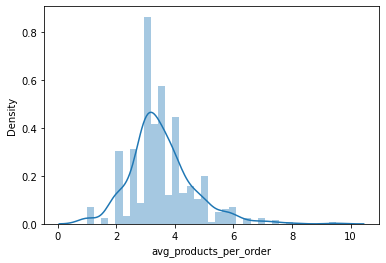

In [46]:
sns.distplot(cg_products_per_order.avg_products_per_order)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


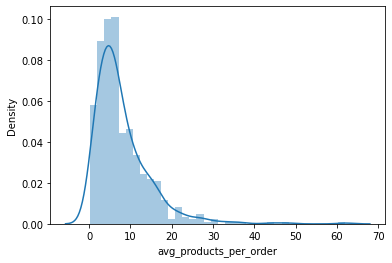

In [47]:
sns.distplot(tg_products_per_order.avg_products_per_order)

Для того, чтобы выбрать, каким тестом здесь воспользоваться, нам нужно для начала проверить наши выборки на нормальность и гомогенность дисперсий.

По графикам очень трудно оценить, являются ли выборки нормальными. Поэтому воспользуемся статистическим тестом Шапиро-Уилка для проверки данных на нормальность.
* Нулевая гипотеза: данные подчиняются нормальному распределению
* Альтернативная гипотеза: данные не подчиняются нормальному распределению

In [57]:
ss.shapiro(cg_products_per_order.avg_products_per_order)

ShapiroResult(statistic=0.9409345984458923, pvalue=1.9475550729411428e-13)

In [59]:
ss.shapiro(tg_products_per_order.avg_products_per_order)

ShapiroResult(statistic=0.7882218360900879, pvalue=5.043604877281564e-25)

Как видим, в обоих случаях pvalue меньше порогового 0.05, а значит мы отвергаем нулевую гипотезу о нормальности распределения.

Далее проверим гомогенность дисперсий. Так как у нас есть отклонения от нормальности, воспользуемся тестом Левена.

* Нулевая гипотеза: выборки имеют гомогенные дисперсии
* Альтернативная гипотеза: выборки не имеют гомогенные дисперсии

In [60]:
ss.levene(cg_products_per_order.avg_products_per_order, tg_products_per_order.avg_products_per_order)

LeveneResult(statistic=221.3199661966309, pvalue=1.973838615727736e-45)

Так как pvalue снова ниже порогового 0.05, то мы также обязаны отклонить нулевую гипотезу: наши выборки имеют разные дисперсии.

Следовательно, для проверки значимости различий между нашими выборками следует воспользоваться т-тестом с поправкой Уэлча на негомогенность дисперсий.

* Нулевая гипотеза: две выборки имеют одинаковые средние значения количества товаров в заказе
* Альтернативная гипотеза: две выборки имеют разные средние значения количества товаров в заказе

In [64]:
ss.ttest_ind(cg_products_per_order.avg_products_per_order, tg_products_per_order.avg_products_per_order, equal_var = False)

Ttest_indResult(statistic=-14.386548665509007, pvalue=8.269572527226482e-40)

Итак, мы получили результат, в котором pvalue существенно отличается от порогового 0.05, таким образом, мы отклоняем нулевую гипотезу и принимаем альтернативную: у нас наблюдаются значимые различия в среднем количестве товаров в заказе.

Вспоминаем, что среднее количество товаров в заказе больше как раз у тестовой группы.

Переходим к изучению среднего чека заказа. \
Воспроизведём предыдущие манипуляции: выделим рассматриваемый признак в отдельные датасеты, визуализируем, проверим на нормальность и гомогенность.

In [65]:
cg_aov = control_group_orders[['user_id', 'avg_order_value']]
tg_aov = test_group_orders[['user_id', 'avg_order_value']]

In [66]:
cg_aov.avg_order_value.mean()

402.1362139451703

In [67]:
tg_aov.avg_order_value.mean()

885.4834306751238

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


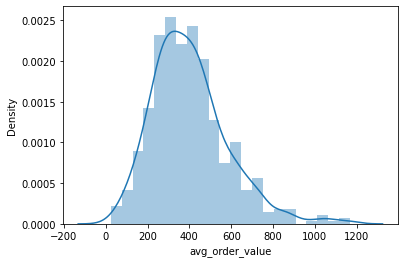

In [68]:
sns.distplot(cg_aov.avg_order_value)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


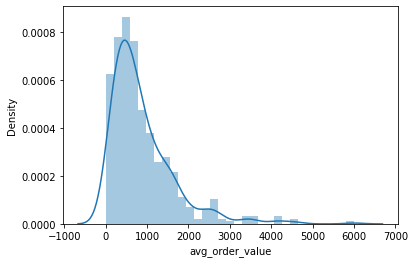

In [69]:
sns.distplot(tg_aov.avg_order_value)

In [70]:
ss.shapiro(cg_aov.avg_order_value)

ShapiroResult(statistic=0.9512741565704346, pvalue=5.3797725822757325e-12)

In [71]:
ss.shapiro(tg_aov.avg_order_value)

ShapiroResult(statistic=0.8043571710586548, pvalue=3.566885464485192e-24)

Снова видим, что ни одна из выборок не подчиняется нормальному распределению.

In [72]:
ss.levene(cg_aov.avg_order_value, tg_aov.avg_order_value)

LeveneResult(statistic=191.39885141704454, pvalue=5.260379214882706e-40)

И дисперсии у нас также разные.

Переходим к самому тесту (с поправкой Уэлча на разность дисперсий, конечно же).

* Нулевая гипотеза: две выборки имеют одинаковый средний чек
* Альтернативная гипотеза: две выборки имеют разный средний чек

In [73]:
ss.ttest_ind(cg_aov.avg_order_value, tg_aov.avg_order_value, equal_var = False)

Ttest_indResult(statistic=-13.458705373535683, pvalue=6.385986217711698e-36)

И вновь мы отклоняем нулевую гипотезу и принимаем альтернативную: у наших двух выборок средний чек имеет статистически значимое различие. И снова эта метрика больше у тестовой группы.

Теперь остаётся только процент отмен заказов. Для начала, как и в предыдущих двух случаях, сделаем необходимые нам преобразования.

Для этого обратимся к исходному фрейму users:

In [77]:
users.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


Выделим заказы в разных статусах в отдельные фреймы:

In [80]:
cancelled_orders = users.query('action == "cancel_order"')
cancelled_orders.head()

,user_id,order_id,action,time,date,group
8,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0
39,993,1296,cancel_order,2022-08-26 00:44:18.150475,2022-08-26,0
47,995,1298,cancel_order,2022-08-26 00:49:51.514240,2022-08-26,0
54,1002,1308,cancel_order,2022-08-26 00:58:01.924112,2022-08-26,1
60,1008,1315,cancel_order,2022-08-26 01:06:11.292953,2022-08-26,0


In [81]:
not_cancelled_orders = users.query("order_id not in @cancelled_orders.order_id").reset_index(drop=True)
not_cancelled_orders.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1
4,968,1261,create_order,2022-08-26 00:05:35.000000,2022-08-26,0


In [88]:
not_cancelled_orders['is_cancelled'] = not_cancelled_orders.order_id.apply(lambda x: 0 if x not in cancelled_orders['order_id'] else 1)

In [89]:
not_cancelled_orders

,user_id,order_id,action,time,date,group,is_cancelled
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,0
3,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,0
4,968,1261,create_order,2022-08-26 00:05:35.000000,2022-08-26,0,0
...,...,...,...,...,...,...,...
3904,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1,0
3905,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1,0
3906,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0,0
3907,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0,0


Так как эта метрика фактически является категориальной (заказ или отменён (1) или нет (0)), то проверять её будем с помощью критерия Хи-квадрат.

Для этого сформируем перекрёстную таблицу.

In [91]:
table = pd.crosstab(not_cancelled_orders['is_cancelled'], not_cancelled_orders['group']).sort_values('is_cancelled', ascending=False)
table

group,0,1
is_cancelled,,
1,34,44
0,1493,2338


* Нулевая гипотеза - % отмен в двух группах статистически значимо не отличается
* Альтернативная гипотеза - % отмен в двух группах статистически значимо отличается

In [92]:
stat, pvalue, dof, freq = ss.chi2_contingency(table)

pvalue

0.47746676578718816

Получившийся результат pvalue первышает пороговый 0.05, из чего следует, что мы не можем отклонить нулевую гипотезу об отсутствии статистически значимых различий.

## Выводы

Благодаря проведённому анализу можно сделать вывод о том, что в тестовой группе статистически значимо выросли метрики среднего количества продуктов в заказе и среднего чека.

При этом % отмен в обеих группах значимо не отличается.

Таким образом, мы можем заключить, что новая система рекомендаций действительно принесла пользу бизнесу и её стоит выкатить на всех пользователей.

### Важно!
Проведённые расчёты и описанные выводы справедливы только при условии того, что алгоритм сплитования, используемый для разбивки пользователей на группы, был честным, и пользователи в двух группах имеют схожие характеристики.